# Ideation



In [1]:
# Imports etc

#!pip install scikit-optimize
!pip install eli5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from collections import deque
from functools import reduce
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_curve, auc
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import GridSearchCV

%matplotlib inline


     |████████████████████████████████| 106 kB 36.2 MB/s 
2021-09-27 02:03:32.522104: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-27 02:03:32.522142: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Get data
global_df = pd.read_csv("nfl_games_and_bets.csv")
global_df = global_df.drop(global_df[global_df.schedule_season == 2021].index)
global_df = global_df.drop(columns=['stadium','weather_temperature', 'weather_wind_mph','weather_humidity','weather_detail'])
global_df = global_df.drop(global_df[global_df.schedule_season < 2010].index)
global_df


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium_neutral
7507,9/9/2010,2010,1,False,New Orleans Saints,14.0,9.0,Minnesota Vikings,NO,-5.0,49.5,False
7508,9/12/2010,2010,1,False,Buffalo Bills,10.0,15.0,Miami Dolphins,MIA,-3.0,39.0,False
7509,9/12/2010,2010,1,False,Chicago Bears,19.0,14.0,Detroit Lions,CHI,-6.5,45.0,False
7510,9/12/2010,2010,1,False,Houston Texans,34.0,24.0,Indianapolis Colts,IND,-1.0,48.0,False
7511,9/12/2010,2010,1,False,Jacksonville Jaguars,24.0,17.0,Denver Broncos,JAX,-3.0,41.5,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10441,1/17/2021,2020,Division,True,Kansas City Chiefs,22.0,17.0,Cleveland Browns,KC,-8.0,56.0,False
10442,1/17/2021,2020,Division,True,New Orleans Saints,20.0,30.0,Tampa Bay Buccaneers,NO,-2.5,53.0,False
10443,1/24/2021,2020,Conference,True,Green Bay Packers,26.0,31.0,Tampa Bay Buccaneers,GB,-3.0,53.0,False
10444,1/24/2021,2020,Conference,True,Kansas City Chiefs,38.0,24.0,Buffalo Bills,KC,-3.0,55.0,False


In [3]:
# Account for team moves
old_to_new_team_name = {"San Diego Chargers": "Los Angeles Chargers", "St. Louis Rams": "Los Angeles Rams", \
"Washington Redskins" : "Washington Football Team", "Oakland Raiders": "Las Vegas Raiders"}
global_df = global_df.replace({"team_away": old_to_new_team_name}).replace({"team_home": old_to_new_team_name})

# Maintain consistency between favourite and team name columns
short_form_to_team_name = {"GB": "Green Bay Packers", "HOU": "Houston Texans", "KC": "Kansas City Chiefs", "BUF": "Buffalo Bills", \
 "TEN": "Tennessee Titans", "NO": "New Orleans Saints", "SEA": "Seattle Seahawks", "MIN": "Minnesota Vikings", \
 "TB": "Tampa Bay Buccaneers", "LVR": "Las Vegas Raiders", "BAL": "Baltimore Ravens", "LAC": "Los Angeles Chargers", \
 "IND": "Indianapolis Colts", "DET": "Detroit Lions", "CLE": "Cleveland Browns", "JAX": "Jacksonville Jaguars", "MIA": "Miami Dolphins", \
 "ARI": "Arizona Cardinals", "PIT": "Pittsburgh Steelers", "CHI": "Chicago Bears","ATL": "Atlanta Falcons", "CAR": "Carolina Panthers", \
 "LAR": "Los Angeles Rams", "CIN": "Cincinnati Bengals", "DAL": "Dallas Cowboys", "SF": "San Francisco 49ers", "NYG": "New York Giants", \
 "WAS": "Washington Football Team", "DEN": "Denver Broncos", "PHI": "Philadelphia Eagles", "NYJ": "New York Jets", "NE": "New England Patriots"}
team_name_to_short_form = {value: key for key, value in short_form_to_team_name.items()}

global_df = global_df.replace({'team_away': team_name_to_short_form}).replace({"team_home": team_name_to_short_form})

# Note: 'PICK' when spread == 0

global_df

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium_neutral
7507,9/9/2010,2010,1,False,NO,14.0,9.0,MIN,NO,-5.0,49.5,False
7508,9/12/2010,2010,1,False,BUF,10.0,15.0,MIA,MIA,-3.0,39.0,False
7509,9/12/2010,2010,1,False,CHI,19.0,14.0,DET,CHI,-6.5,45.0,False
7510,9/12/2010,2010,1,False,HOU,34.0,24.0,IND,IND,-1.0,48.0,False
7511,9/12/2010,2010,1,False,JAX,24.0,17.0,DEN,JAX,-3.0,41.5,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10441,1/17/2021,2020,Division,True,KC,22.0,17.0,CLE,KC,-8.0,56.0,False
10442,1/17/2021,2020,Division,True,NO,20.0,30.0,TB,NO,-2.5,53.0,False
10443,1/24/2021,2020,Conference,True,GB,26.0,31.0,TB,GB,-3.0,53.0,False
10444,1/24/2021,2020,Conference,True,KC,38.0,24.0,BUF,KC,-3.0,55.0,False


# Columns I'd like to add
* Last game result (plus/minus) -- have enough data, but need to account for bye
* Last few games results -- have enough data, also need to account for bye (maybe W in last 3, or total point difference in last 3)
* Covered spread last game (bool) - have enough data
* Who covered spread this game -- already a column but may need to feature engineer a bit
* wind direction / speed - not enough data
* divisional - have enough data but need to build the dataset manually
* prime time - don't have enough data
* twitter sentiment - don't have enough data
* garbage game ? - can use schedule_date maybe

In [4]:
# Determine if teams are within the same division

# AFC = A, NFC = N
# West = W, etc etc
team_to_division = {"ARI": "NW", "LAR": "NW", "SF": "NW", "SEA": "NW", "CAR": "NS", "TB": "NS", "NO": "NS", "ATL": "NS", \
 "GB": "NN", "CHI": "NN", "MIN": "NN", "DET": "NN", "WAS": "NE", "DAL": "NE", "PHI": "NE", "NYG": "NE", \
 "TEN": "AS", "HOU": "AS", "IND": "AS", "JAX": "AS", "BUF": "AE", "MIA": "AE", "NE": "AE", "NYJ": "AE", \
 "BAL": "AN", "PIT": "AN", "CLE": "AN", "CIN": "AN", "LVR": "AW", "DEN": "AW", "KC": "AW", "LAC": "AW"}

global_df2 = global_df
global_df2['home_division'] = global_df2.apply(lambda row: team_to_division[row.team_home], axis=1)
global_df2['away_division'] = global_df2.apply(lambda row: team_to_division[row.team_away], axis=1)
global_df2['intra_division'] = global_df2.apply(lambda row: row.home_division == row.away_division, axis=1)
global_df2 = global_df2.drop(columns=['home_division', 'away_division'])
global_df2



,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium_neutral,intra_division
7507,9/9/2010,2010,1,False,NO,14.0,9.0,MIN,NO,-5.0,49.5,False,False
7508,9/12/2010,2010,1,False,BUF,10.0,15.0,MIA,MIA,-3.0,39.0,False,True
7509,9/12/2010,2010,1,False,CHI,19.0,14.0,DET,CHI,-6.5,45.0,False,True
7510,9/12/2010,2010,1,False,HOU,34.0,24.0,IND,IND,-1.0,48.0,False,True
7511,9/12/2010,2010,1,False,JAX,24.0,17.0,DEN,JAX,-3.0,41.5,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10441,1/17/2021,2020,Division,True,KC,22.0,17.0,CLE,KC,-8.0,56.0,False,False
10442,1/17/2021,2020,Division,True,NO,20.0,30.0,TB,NO,-2.5,53.0,False,True
10443,1/24/2021,2020,Conference,True,GB,26.0,31.0,TB,GB,-3.0,53.0,False,False
10444,1/24/2021,2020,Conference,True,KC,38.0,24.0,BUF,KC,-3.0,55.0,False,False


In [5]:
# Create auxillary columns to make calculations easier
global_df3 = global_df2
global_df3['home_point_diff'] = global_df2.apply(lambda row: row.score_home - row.score_away, axis=1)
global_df3['away_point_diff'] = global_df3.apply(lambda row: row.score_away - row.score_home, axis=1)
global_df3['home_spread'] = global_df3.apply(lambda row: row.spread_favorite * -1 if row.team_favorite_id == row.team_away else row.spread_favorite, axis=1)

# Loop, sorry pandas 
team_to_games = {}

# Get last one result
for index, row in global_df3.iterrows():

    # Update the mapping
    if row.team_home not in team_to_games:
        team_to_games.update({row.team_home : deque([0,0,0])})

    if row.team_away not in team_to_games:
        team_to_games.update({row.team_away : deque([0,0,0])})

    last_games = team_to_games.get(row.team_home)
    home_last_3 = last_games[0] + last_games[1] + last_games[2]
    home_last_1 = last_games[0]
    last_games.pop()
    last_games.appendleft(row.home_point_diff)

    last_games = team_to_games.get(row.team_away)
    away_last_3 = last_games[0] + last_games[1] + last_games[2]
    away_last_1 = last_games[0]
    last_games.pop()
    last_games.appendleft(row.away_point_diff)

    global_df3.at[index, 'home_last_3'] = home_last_3
    global_df3.at[index, 'away_last_3'] = away_last_3
    global_df3.at[index, 'home_last_1'] = home_last_1
    global_df3.at[index, 'away_last_1'] = away_last_1

    # Update the DF


team_to_games


#global_df3['home_last_game_result'] = global_df3.groupby('')


#global_df3
#team_to_games.get("TB")[0]




{'NO': deque([-10.0, 12.0, 26.0]),
 'MIN': deque([2.0, -19.0, -6.0]),
 'BUF': deque([-14.0, 14.0, 3.0]),
 'MIA': deque([-30.0, 1.0, 10.0]),
 'CHI': deque([-12.0, -19.0, 24.0]),
 'DET': deque([-2.0, -40.0, -21.0]),
 'HOU': deque([-3.0, -6.0, -7.0]),
 'IND': deque([-3.0, 14.0, -4.0]),
 'JAX': deque([-14.0, -24.0, -26.0]),
 'DEN': deque([-1.0, -3.0, -29.0]),
 'NE': deque([14.0, -29.0, -10.0]),
 'CIN': deque([-35.0, 6.0, 10.0]),
 'NYG': deque([4.0, -14.0, -14.0]),
 'CAR': deque([-26.0, 7.0, -8.0]),
 'PHI': deque([-6.0, -20.0, -7.0]),
 'GB': deque([-5.0, 14.0, 19.0]),
 'PIT': deque([-11.0, -2.0, 4.0]),
 'ATL': deque([-17.0, -3.0, -4.0]),
 'SEA': deque([-10.0, 3.0, 11.0]),
 'SF': deque([-3.0, 8.0, -8.0]),
 'LAR': deque([-14.0, 10.0, 11.0]),
 'ARI': deque([-11.0, -8.0, 7.0]),
 'TB': deque([22.0, 5.0, 10.0]),
 'CLE': deque([-5.0, 11.0, 2.0]),
 'TEN': deque([-7.0, 3.0, -26.0]),
 'LVR': deque([1.0, -1.0, -3.0]),
 'WAS': deque([-8.0, 6.0, -7.0]),
 'DAL': deque([-4.0, 20.0, 8.0]),
 'KC': deque([-2

In [6]:
global_df3

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium_neutral,intra_division,home_point_diff,away_point_diff,home_spread,home_last_3,away_last_3,home_last_1,away_last_1
7507,9/9/2010,2010,1,False,NO,14.0,9.0,MIN,NO,-5.0,49.5,False,False,5.0,-5.0,-5.0,0.0,0.0,0.0,0.0
7508,9/12/2010,2010,1,False,BUF,10.0,15.0,MIA,MIA,-3.0,39.0,False,True,-5.0,5.0,3.0,0.0,0.0,0.0,0.0
7509,9/12/2010,2010,1,False,CHI,19.0,14.0,DET,CHI,-6.5,45.0,False,True,5.0,-5.0,-6.5,0.0,0.0,0.0,0.0
7510,9/12/2010,2010,1,False,HOU,34.0,24.0,IND,IND,-1.0,48.0,False,True,10.0,-10.0,1.0,0.0,0.0,0.0,0.0
7511,9/12/2010,2010,1,False,JAX,24.0,17.0,DEN,JAX,-3.0,41.5,False,False,7.0,-7.0,-3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10441,1/17/2021,2020,Division,True,KC,22.0,17.0,CLE,KC,-8.0,56.0,False,False,5.0,-5.0,-8.0,-11.0,6.0,-17.0,11.0
10442,1/17/2021,2020,Division,True,NO,20.0,30.0,TB,NO,-2.5,53.0,False,True,-10.0,10.0,-2.5,57.0,65.0,12.0,8.0
10443,1/24/2021,2020,Conference,True,GB,26.0,31.0,TB,GB,-3.0,53.0,False,False,-5.0,5.0,-3.0,59.0,35.0,14.0,10.0
10444,1/24/2021,2020,Conference,True,KC,38.0,24.0,BUF,KC,-3.0,55.0,False,False,14.0,-14.0,-3.0,-9.0,47.0,5.0,14.0


[Text(0.5, 0, 'schedule_season'),
 Text(1.5, 0, 'schedule_playoff'),
 Text(2.5, 0, 'over_under_line'),
 Text(3.5, 0, 'intra_division'),
 Text(4.5, 0, 'home_point_diff'),
 Text(5.5, 0, 'home_spread'),
 Text(6.5, 0, 'home_last_3'),
 Text(7.5, 0, 'away_last_3'),
 Text(8.5, 0, 'home_last_1'),
 Text(9.5, 0, 'away_last_1'),
 Text(10.5, 0, 'home_team_covered')]

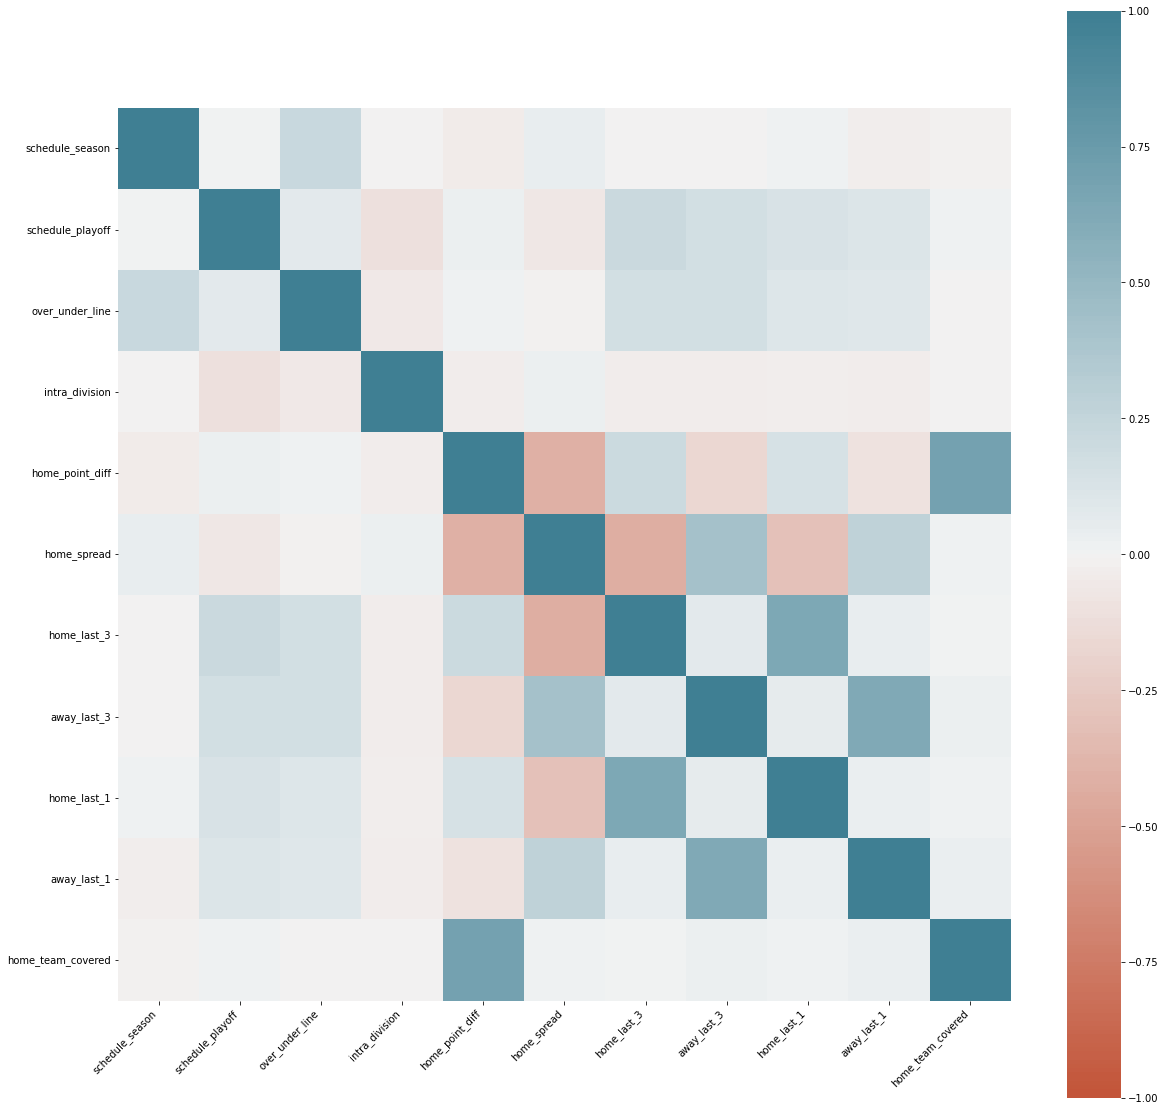

In [7]:
global_df_final = global_df3

global_df_final['home_team_covered'] = global_df_final.apply(lambda row: row.home_point_diff + row.home_spread > 0, axis=1)
global_df_final_no_drop = global_df_final


global_df_final = global_df_final.drop(columns = ['schedule_date', 'schedule_week', 'team_home', 'score_home', 'score_away', 'team_away', \
 'team_favorite_id', 'spread_favorite', 'away_point_diff'])

# Correlation
corr = global_df_final.corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

#global_df_final


In [8]:
# Regressor

train_data = global_df_final.drop(['home_team_covered', 'home_point_diff'], axis=1)
target_label = global_df_final['home_point_diff']

n_features = train_data.shape[1]
x_train, x_test, y_train, y_test = train_test_split(train_data, target_label, test_size = 0.30)

parameters = {
    "n_estimators":[5,50, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1]
}

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

gbc = ensemble.GradientBoostingRegressor()

cv = GridSearchCV(gbc,parameters,cv=5)
cv.fit(x_train, y_train)

display(cv)

Best parameters are: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}


0.005 + or -0.003 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.067 + or -0.003 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.106 + or -0.006 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}
0.012 + or -0.003 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.102 + or -0.005 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.141 + or -0.012 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.013 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.103 + or -0.004 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.134 + or -0.011 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.013 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 5}
0.095 + or -0.007 for the {'learning_rate': 0.01, 'max_dept

In [9]:
train_data2 = global_df_final.drop(['home_team_covered', 'home_point_diff'], axis=1)
target_label2 = global_df_final['home_point_diff']

y_pred_full = cv.predict(train_data2)


global_df_final_no_drop["predicted_diff"] = y_pred_full
global_df_final_no_drop

#y_pred_full = cv.predict(x_test)

#len(y_pred_full)

#df_with_predictions = global_df3

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,intra_division,home_point_diff,away_point_diff,home_spread,home_last_3,away_last_3,home_last_1,away_last_1,home_team_covered,predicted_diff
7507,9/9/2010,2010,1,False,NO,14.0,9.0,MIN,NO,-5.0,...,False,5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,False,5.083362
7508,9/12/2010,2010,1,False,BUF,10.0,15.0,MIA,MIA,-3.0,...,True,-5.0,5.0,3.0,0.0,0.0,0.0,0.0,False,-0.298498
7509,9/12/2010,2010,1,False,CHI,19.0,14.0,DET,CHI,-6.5,...,True,5.0,-5.0,-6.5,0.0,0.0,0.0,0.0,False,6.403257
7510,9/12/2010,2010,1,False,HOU,34.0,24.0,IND,IND,-1.0,...,True,10.0,-10.0,1.0,0.0,0.0,0.0,0.0,True,0.857487
7511,9/12/2010,2010,1,False,JAX,24.0,17.0,DEN,JAX,-3.0,...,False,7.0,-7.0,-3.0,0.0,0.0,0.0,0.0,True,2.066467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10441,1/17/2021,2020,Division,True,KC,22.0,17.0,CLE,KC,-8.0,...,False,5.0,-5.0,-8.0,-11.0,6.0,-17.0,11.0,False,6.975492
10442,1/17/2021,2020,Division,True,NO,20.0,30.0,TB,NO,-2.5,...,True,-10.0,10.0,-2.5,57.0,65.0,12.0,8.0,False,1.551171
10443,1/24/2021,2020,Conference,True,GB,26.0,31.0,TB,GB,-3.0,...,False,-5.0,5.0,-3.0,59.0,35.0,14.0,10.0,False,1.864507
10444,1/24/2021,2020,Conference,True,KC,38.0,24.0,BUF,KC,-3.0,...,False,14.0,-14.0,-3.0,-9.0,47.0,5.0,14.0,True,1.432883


In [10]:
perm = PermutationImportance(cv).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.2850 ± 0.0172,home_spread
0.0002 ± 0.0009,schedule_season
0 ± 0.0000,away_last_1
0 ± 0.0000,home_last_1
0 ± 0.0000,away_last_3
0 ± 0.0000,stadium_neutral
0 ± 0.0000,over_under_line
0 ± 0.0000,schedule_playoff
-0.0004 ± 0.0005,intra_division
-0.0015 ± 0.0052,home_last_3


In [11]:
# Ultimate backtester!!!!

# integer, last two are the decimals. start with $100.00. Each bet is $3
# assume even -110 odds on everything. so bet $3 = win $2.73
money = 10000
won = 0
loss = 0
push = 0

for row in global_df_final_no_drop.itertuples():

    if row.predicted_diff + row.home_spread > 2:
        print(row)
        if row.home_point_diff + row.home_spread > 0:
            money = money + 273
            won += 1
        elif row.home_point_diff + row.home_spread == 0:
            push +=1
        else:
            money = money - 300
            loss += 1
    if row.predicted_diff + row.home_spread < -2:
        print(row)
        if row.away_point_diff - row.home_spread > 0:
            money = money - 300
            loss += 1
        elif row.away_point_diff - row.home_spread == 0:
            push +=1
        else:
            money = money + 273
            won += 1

print (money)
print (won)
print (loss)
print (push)



Pandas(Index=7508, schedule_date='9/12/2010', schedule_season=2010, schedule_week='1', schedule_playoff=False, team_home='BUF', score_home=10.0, score_away=15.0, team_away='MIA', team_favorite_id='MIA', spread_favorite=-3.0, over_under_line=39.0, stadium_neutral=False, intra_division=True, home_point_diff=-5.0, away_point_diff=5.0, home_spread=3.0, home_last_3=0.0, away_last_3=0.0, home_last_1=0.0, away_last_1=0.0, home_team_covered=False, predicted_diff=-0.29849756811449324)
Pandas(Index=7514, schedule_date='9/12/2010', schedule_season=2010, schedule_week='1', schedule_playoff=False, team_home='PHI', score_home=20.0, score_away=27.0, team_away='GB', team_favorite_id='GB', spread_favorite=-3.0, over_under_line=48.0, stadium_neutral=False, intra_division=False, home_point_diff=-7.0, away_point_diff=7.0, home_spread=3.0, home_last_3=0.0, away_last_3=0.0, home_last_1=0.0, away_last_1=0.0, home_team_covered=False, predicted_diff=-0.13858341384360268)
Pandas(Index=7515, schedule_date='9/12/

In [15]:
# the fields most correlated with 'home_team_covered' is away_last_3 (positively)
# so, what if i always bet the home team when away_last_3 is > some value

global_df_final_no_drop.describe()

#away last 3: 75% = 20


money = 10000
won = 0
loss = 0
push = 0

for row in global_df_final_no_drop.itertuples():

#   if (row.away_last_3 < -30 and row.away_last_1 < 0 and row.intra_division):
    if (row.away_last_1 <= -14 and row.intra_division and row.home_spread < 0): #bet on road underdog 
        if row.away_point_diff - row.home_spread > 0:
            money = money + 273
            won += 1
        elif row.away_point_diff - row.home_spread > 0:
            push +=1
        else:
            money = money - 300
            loss += 1


print (money)
print (won)
print (loss)
print (push)


11770
90
76
0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f0efbe77-01fa-4860-b5ee-e7eac30d44e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>